<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/verao_covid_obitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io
import gzip
import pandas as pd
import seaborn as sns; sns.set_theme(style="whitegrid")

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, parse_dates=["date"], dtype={"city_ibge_code": str})

In [ ]:
cols = "MUNICIPIO","COD_IBGE","CLUSTER","UF","ARRECADACAO","QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL"
cidades_turisticas = pd.read_excel('https://github.com/mirianbatista/covid-fatores/blob/master/RELATORIO_CATEGORIZACAO_2019-Portal.xls?raw=true', usecols=cols, dtype={"COD_IBGE": str})
cidades = cidades_turisticas.MUNICIPIO.to_list()

In [ ]:
cidades_turisticas[cidades_turisticas.isna().any(axis=1)]

,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER


In [ ]:
covid_cidades_turisticas = covid.loc[covid['city'].isin(cidades)]
covid_cidades_turisticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182025 entries, 0 to 2337326
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype         
---  ------                                         --------------    -----         
 0   city                                           1182025 non-null  object        
 1   city_ibge_code                                 1182025 non-null  object        
 2   date                                           1182025 non-null  datetime64[ns]
 3   epidemiological_week                           1182025 non-null  int64         
 4   estimated_population                           1182025 non-null  float64       
 5   estimated_population_2019                      1182025 non-null  float64       
 6   is_last                                        1182025 non-null  bool          
 7   is_repeated                                    1182025 non-null  bool          
 8   last_available_confirmed        

In [ ]:
covid_cidades_turisticas.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
covid_tur = pd.merge(covid_cidades_turisticas, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left").dropna(subset=['CLUSTER'])
covid_tur = covid_tur[covid_tur.estimated_population >= 20000]

In [ ]:
def aumento_percentual(t0, t1):
  return (t1-t0)/t0 if t0 != 0 else 0

def calcula_aumento_relativo(df, x_col, date_col, from_date, to_date):
    from_x = int(df[df[date_col] == from_date][x_col])
    to_x = int(df[df[date_col] == to_date][x_col])
    abs_dif = to_x - from_x
    relative_dif = aumento_percentual(from_x, to_x)
    return {f'{x_col}_from': from_x, f'{x_col}_to': to_x, 'dif': abs_dif,'relative_dif': relative_dif}

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2020-12-17', to_date='2021-03-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
866,4106506,20580.0,2.0,39.0,37.0,18.500000
395,2923605,21695.0,1.0,12.0,11.0,11.000000
825,3551603,29452.0,3.0,22.0,19.0,6.333333
555,3171006,20642.0,5.0,32.0,27.0,5.400000
1018,4313201,21536.0,4.0,25.0,21.0,5.250000
...,...,...,...,...,...,...
242,2601607,20730.0,0.0,5.0,5.0,0.000000
210,2414407,33503.0,24.0,24.0,0.0,0.000000
107,2103174,21840.0,7.0,7.0,0.0,0.000000
118,2108306,38731.0,9.0,9.0,0.0,0.000000


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,120.0,255.0,135.0,1.125000,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,51.0,125.0,74.0,1.450980,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,94.0,150.0,56.0,0.595745,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,29.0,66.0,37.0,1.275862,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,14.0,40.0,26.0,1.857143,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,1.0,4.0,3.0,3.000000,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,172.0,230.0,58.0,0.337209,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,30.0,47.0,17.0,0.566667,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,135.0,187.0,52.0,0.385185,GO,Valparaíso de Goiás,5221858,3064,746468,D


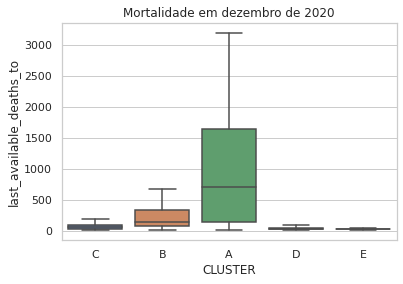

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em dezembro de 2020")

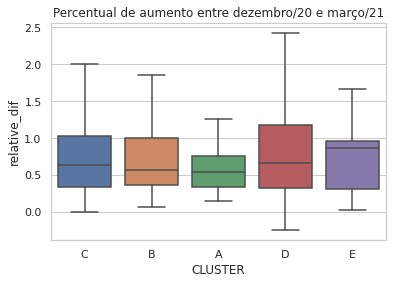

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre dezembro/20 e março/21")

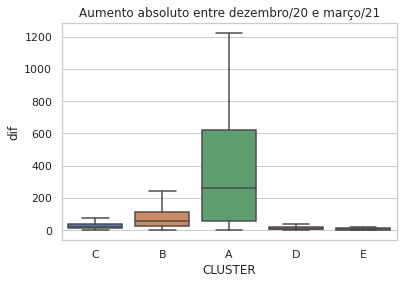

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre dezembro/20 e março/21")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1287.881356,455.0,1865.508475,705.0,577.627119,262.0,0.592370,0.536103,0.469390
1,B,238,183898.054622,123057.0,159.529412,85.0,250.113445,143.0,90.584034,58.0,0.782802,0.572646,0.692379
2,C,397,74728.382872,51338.0,58.221662,32.0,91.327456,52.0,33.105793,20.0,0.821278,0.634146,0.709165
3,D,450,39418.280000,30428.5,25.397778,16.0,39.795556,28.0,14.397778,10.0,0.933492,0.666667,0.805825
4,E,11,39515.181818,24382.0,20.454545,14.0,35.454545,24.0,15.000000,8.0,0.729664,0.866667,0.870311


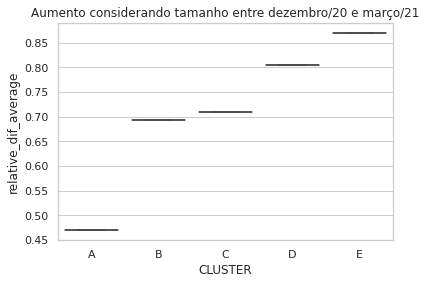

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre dezembro/20 e março/21")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,262.0
1,B,58.0
2,C,20.0
3,D,10.0
4,E,8.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
4,E,0.866667
3,D,0.666667
2,C,0.634146
1,B,0.572646
0,A,0.536103


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.870311
3,D,0.805825
2,C,0.709165
1,B,0.692379
0,A,0.469390


In [ ]:
covid_tur_aumento_categorias.groupby('CLUSTER')['UF'].value_counts().to_frame().unstack()

UF                              ...                                  
UF        AC    AL   AM   AP    BA    CE  ...   RR    RS    SC    SE    SP   TO
CLUSTER                                   ...                                  
A        1.0   2.0  1.0  1.0   4.0   2.0  ...  1.0   2.0   5.0   1.0  11.0  1.0
B        NaN   1.0  NaN  NaN  19.0  12.0  ...  NaN  21.0  15.0   NaN  46.0  2.0
C        2.0   6.0  9.0  2.0  25.0  23.0  ...  NaN  29.0  18.0   6.0  73.0  5.0
D        3.0  16.0  9.0  1.0  30.0  15.0  ...  1.0  41.0  17.0  13.0  67.0  1.0
E        NaN   2.0  NaN  NaN   3.0   1.0  ...  NaN   NaN   1.0   NaN   1.0  NaN

[5 rows x 27 columns]

http://dados.turismo.gov.br/categorizacao


# **Entre 17 de dezembro de 2020 e 16 de janeiro de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2020-12-17', to_date='2021-01-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
395,2923605,21695.0,1.0,6.0,5.0,5.000000
866,4106506,20580.0,2.0,8.0,6.0,3.000000
985,4304200,31421.0,5.0,16.0,11.0,2.200000
527,3154002,23711.0,4.0,12.0,8.0,2.000000
496,3141801,31497.0,2.0,5.0,3.0,1.500000
...,...,...,...,...,...,...
50,1502707,47991.0,28.0,28.0,0.0,0.000000
266,2609501,32573.0,30.0,30.0,0.0,0.000000
210,2414407,33503.0,24.0,23.0,-1.0,-0.041667
802,3546306,34737.0,24.0,23.0,-1.0,-0.041667


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,120.0,159.0,39.0,0.325000,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,51.0,73.0,22.0,0.431373,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,94.0,95.0,1.0,0.010638,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,29.0,37.0,8.0,0.275862,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,14.0,20.0,6.0,0.428571,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,1.0,2.0,1.0,1.000000,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,172.0,181.0,9.0,0.052326,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,30.0,30.0,0.0,0.000000,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,135.0,149.0,14.0,0.103704,GO,Valparaíso de Goiás,5221858,3064,746468,D


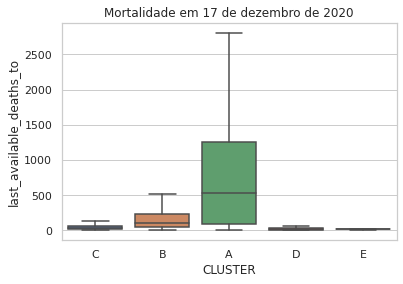

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em 17 de dezembro de 2020")

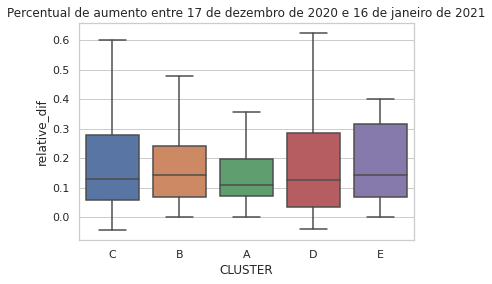

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

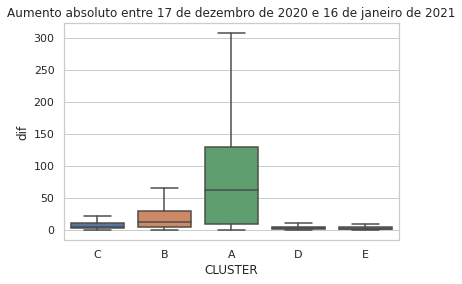

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1287.881356,455.0,1430.593220,526.0,142.711864,62.0,0.138631,0.107368,0.113569
1,B,238,183898.054622,123057.0,159.529412,85.0,182.243697,102.0,22.714286,12.0,0.181226,0.142857,0.165877
2,C,397,74728.382872,51338.0,58.221662,32.0,66.690176,36.0,8.468514,4.0,0.199456,0.128713,0.177411
3,D,450,39418.280000,30428.5,25.397778,16.0,28.931111,19.0,3.533333,2.0,0.218234,0.126500,0.190813
4,E,11,39515.181818,24382.0,20.454545,14.0,25.000000,18.0,4.545455,1.0,0.223691,0.142857,0.258725


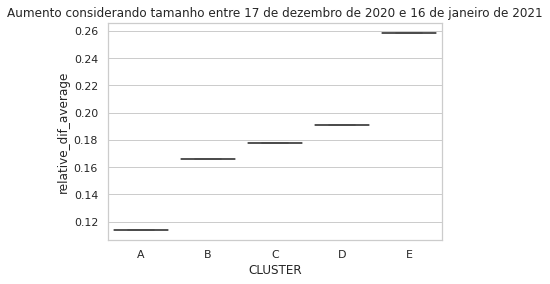

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,62.0
1,B,12.0
2,C,4.0
3,D,2.0
4,E,1.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.142857
4,E,0.142857
2,C,0.128713
3,D,0.126500
0,A,0.107368


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.258725
3,D,0.190813
2,C,0.177411
1,B,0.165877
0,A,0.113569


# **Entre 17 de janeiro de 2021 e 16 de fevereiro de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-01-17', to_date='2021-02-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
884,4113304,32139.0,3.0,8.0,5.0,1.666667
508,3146008,33791.0,10.0,26.0,16.0,1.600000
510,3146305,20252.0,4.0,10.0,6.0,1.500000
523,3152006,32035.0,6.0,15.0,9.0,1.500000
20,1301100,38348.0,29.0,72.0,43.0,1.482759
...,...,...,...,...,...,...
178,2311603,29146.0,47.0,46.0,-1.0,-0.021277
645,3306206,37083.0,30.0,29.0,-1.0,-0.033333
163,2306553,42215.0,29.0,28.0,-1.0,-0.034483
210,2414407,33503.0,23.0,22.0,-1.0,-0.043478


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,160.0,200.0,40.0,0.250000,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,75.0,97.0,22.0,0.293333,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,96.0,126.0,30.0,0.312500,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,37.0,46.0,9.0,0.243243,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,20.0,32.0,12.0,0.600000,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,2.0,2.0,0.0,0.000000,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,181.0,195.0,14.0,0.077348,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,30.0,36.0,6.0,0.200000,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,149.0,158.0,9.0,0.060403,GO,Valparaíso de Goiás,5221858,3064,746468,D


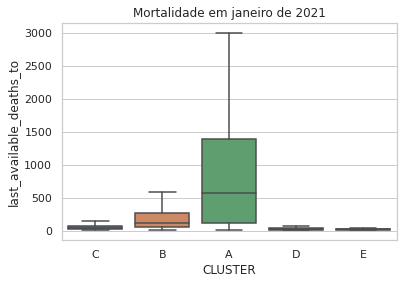

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em janeiro de 2021")

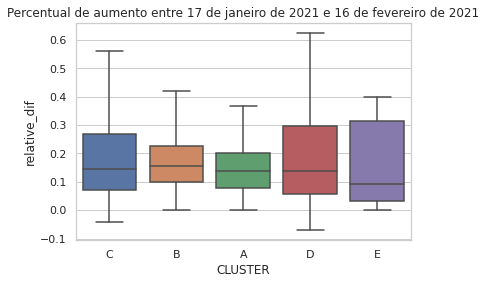

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

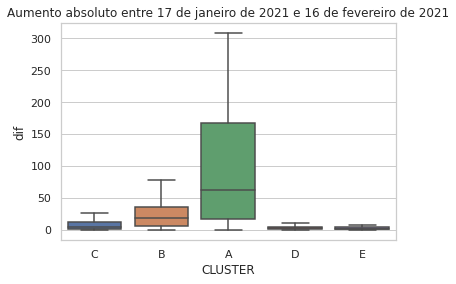

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1433.610169,526.0,1637.101695,575.0,203.491525,63.0,0.160324,0.137602,0.140029
1,B,238,183898.054622,123057.0,182.600840,102.0,210.819328,118.0,28.218487,18.0,0.194312,0.156363,0.176176
2,C,397,74728.382872,51338.0,66.869018,36.0,77.365239,46.0,10.496222,5.0,0.208995,0.144444,0.181939
3,D,450,39418.280000,30428.5,29.013333,19.0,33.184444,23.0,4.171111,3.0,0.216091,0.136364,0.189546
4,E,11,39515.181818,24382.0,25.181818,18.0,30.636364,20.0,5.454545,2.0,0.159309,0.090909,0.241147


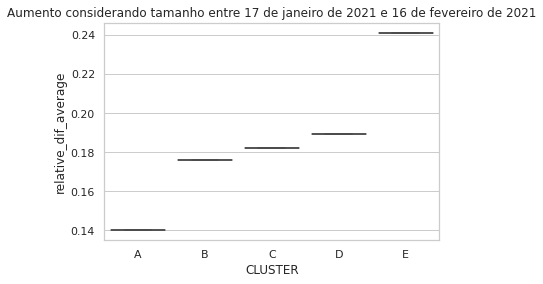

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,63.0
1,B,18.0
2,C,5.0
3,D,3.0
4,E,2.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.156363
2,C,0.144444
0,A,0.137602
3,D,0.136364
4,E,0.090909


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.241147
3,D,0.189546
2,C,0.181939
1,B,0.176176
0,A,0.140029


# **Entre 17 de fevereiro de 2021 e 16 de março de 2021**

In [ ]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-02-17', to_date='2021-03-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
555,3171006,20642.0,10.0,32.0,22.0,2.200000
1014,4311007,26500.0,6.0,17.0,11.0,1.833333
893,4117701,33994.0,10.0,28.0,18.0,1.800000
866,4106506,20580.0,14.0,39.0,25.0,1.785714
372,2914406,25478.0,3.0,8.0,5.0,1.666667
...,...,...,...,...,...,...
74,1507458,24705.0,20.0,20.0,0.0,0.000000
246,2602308,38117.0,28.0,28.0,0.0,0.000000
188,2314102,61410.0,63.0,63.0,0.0,0.000000
440,3109402,28121.0,16.0,15.0,-1.0,-0.062500


In [ ]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
0,1100023,109523.0,204.0,255.0,51.0,0.250000,RO,Ariquemes,1100023,3371,739140,C
1,1100049,85893.0,97.0,125.0,28.0,0.288660,RO,Cacoal,1100049,98548,866406,B
2,1100106,46556.0,131.0,150.0,19.0,0.145038,RO,Guajará-Mirim,1100106,34819,72309,C
3,1100155,35737.0,46.0,66.0,20.0,0.434783,RO,Ouro Preto do Oeste,1100155,9645,0,C
4,1100189,36881.0,32.0,40.0,8.0,0.250000,RO,Pimenta Bueno,1100189,29225,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1150,5220603,20816.0,2.0,4.0,2.0,1.000000,GO,Silvânia,5220603,12425,0,D
1151,5221403,129823.0,196.0,230.0,34.0,0.173469,GO,Trindade,5221403,193242,546770,B
1152,5221601,40840.0,36.0,47.0,11.0,0.305556,GO,Uruaçu,5221601,215680,375239,B
1153,5221858,172135.0,159.0,187.0,28.0,0.176101,GO,Valparaíso de Goiás,5221858,3064,746468,D


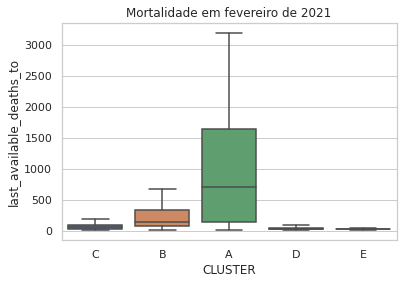

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias, showfliers = False).set_title("Mortalidade em fevereiro de 2021")

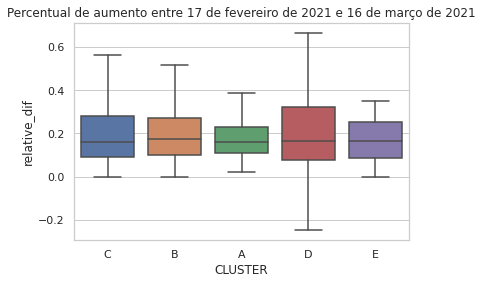

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Percentual de aumento entre 17 de fevereiro de 2021 e 16 de março de 2021")

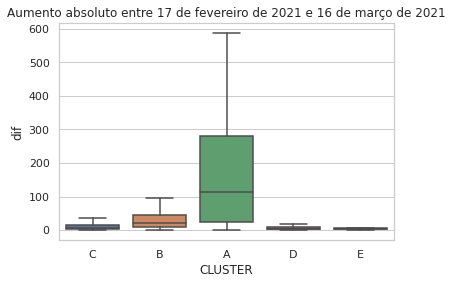

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False).set_title("Aumento absoluto entre 17 de fevereiro de 2021 e 16 de março de 2021")

In [ ]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [ ]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1645.033898,580.0,1865.508475,705.0,220.474576,114.0,0.189079,0.159794,0.142200
1,B,238,183898.054622,123057.0,211.857143,118.0,250.113445,143.0,38.256303,22.0,0.226293,0.171786,0.204690
2,C,397,74728.382872,51338.0,77.725441,46.0,91.327456,52.0,13.602015,7.0,0.217472,0.157895,0.195683
3,D,450,39418.280000,30428.5,33.353333,23.0,39.795556,28.0,6.442222,4.0,0.246462,0.166667,0.224332
4,E,11,39515.181818,24382.0,30.636364,20.0,35.454545,24.0,4.818182,4.0,0.202046,0.166667,0.190595


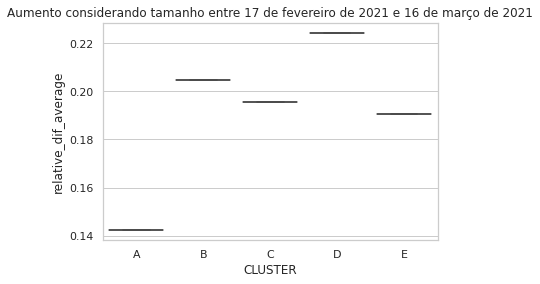

In [ ]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de fevereiro de 2021 e 16 de março de 2021")

**Métricas em ordem decrescente**

In [ ]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,114.0
1,B,22.0
2,C,7.0
3,D,4.0
4,E,4.0


In [ ]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.171786
3,D,0.166667
4,E,0.166667
0,A,0.159794
2,C,0.157895


In [ ]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
3,D,0.224332
1,B,0.204690
2,C,0.195683
4,E,0.190595
0,A,0.142200
